# AB TESTING PROJECT

### Testing Process
- Understanding business problem & data
- Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
- Look summary stats and plots
- Apply hypothesis testing and check assumptions
    - Check Normality & Homogeneity
    - Apply tests (D’Agostino Omnibus test , Levene Test, T-Test, Welch Test, Mann Whitney U Test)
- Evaluate the results
- Make inferences
- Recommend business decision to your customer/director/ceo etc.

## Understanding business problem & data

### Data Loading 

In [73]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [74]:
df = pd.read_csv('cookie_cats.csv')

In [75]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data is from 90,189 players that installed the game while the df-test was running. 
The variables are:

**userid** - a unique number that identifies each player.<br />
**version** - whether the player was put in the control group (*gate_30* - a gate at level 30) or the test group (*gate_40* - a gate at level 40).<br />
**sum_gamerounds** - the number of game rounds played by the player during the first week after installation<br />
**retention_1** - did the player come back and play 1 day after installing?<br />
**retention_7** - did the player come back and play 7 days after installing?<br />
When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

**Project target:** where the first gate in Cookie Cats was moved from level 30 to level 40, for improving the player retention and game rounds.

**Core index:** player retention(retention_1 & retention_7) and game rounds (sum_gamerounds).

## Detect and resolve problems in the data

### Data description

In [76]:
# Number of Unique User
print(df.userid.nunique() == df.shape[0])
# Check missing values
np.where(pd.isnull(df))
# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


(array([], dtype=int64), array([], dtype=int64))

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


### Count the number of players in each group

In [77]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


The number of each group is roughly the same in the control group (gate_30) and test group (gate_40)

In [78]:
# A/B Groups & Target Summary Stats
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

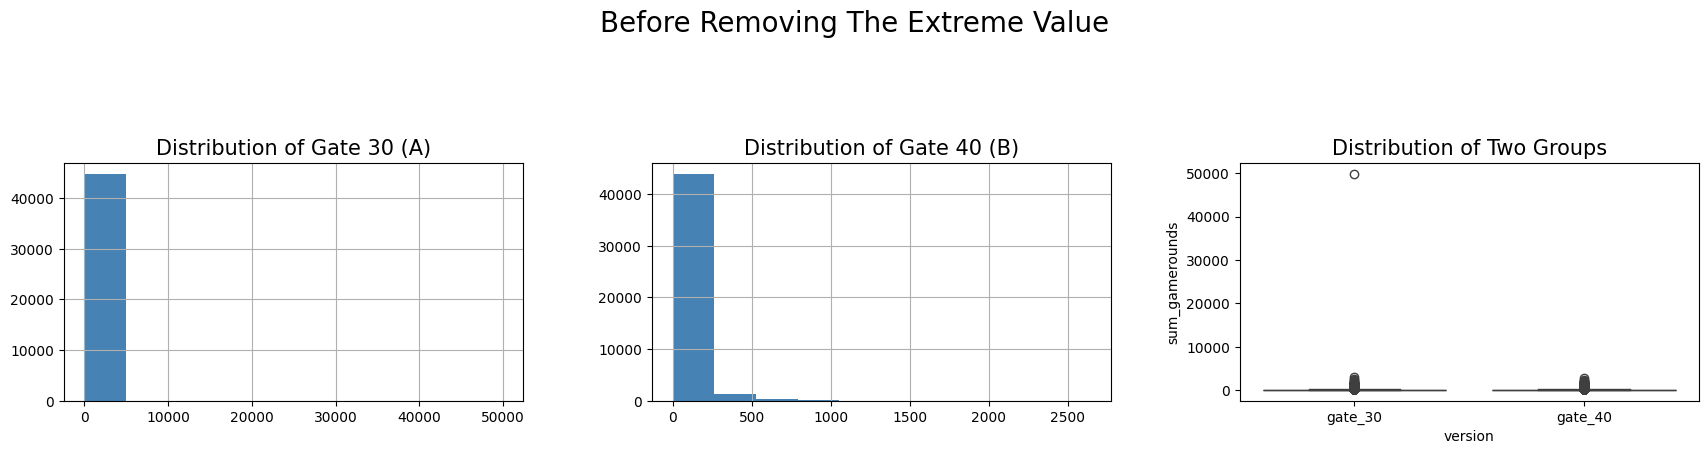

In [80]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

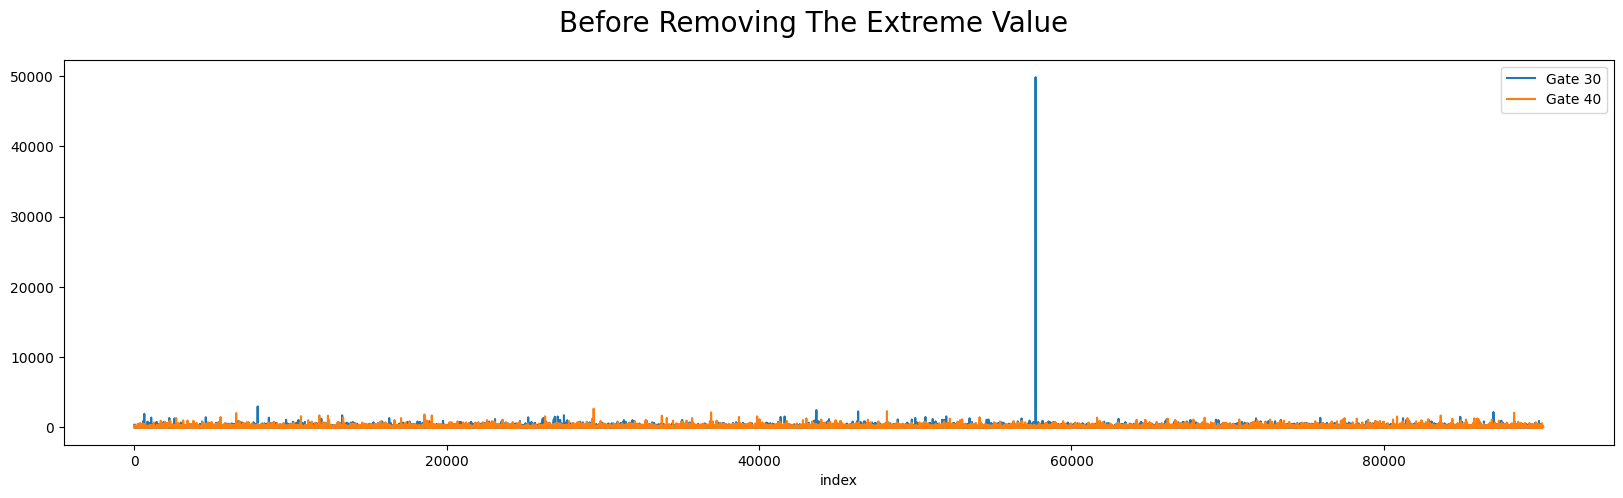

In [81]:
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

The distribution of Gate_30 and Gate_40 are similar, except one outlier in gate_30. 

### OUTLIERS

In [82]:
# remove the outlier
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,2961.0


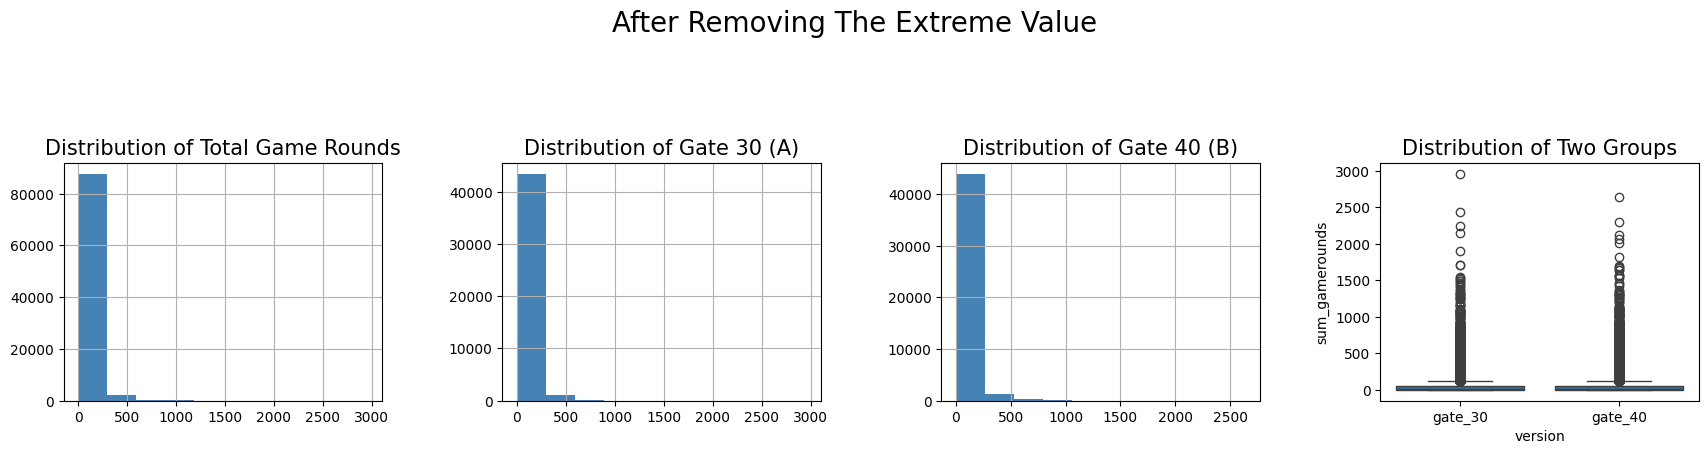

In [83]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
df.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

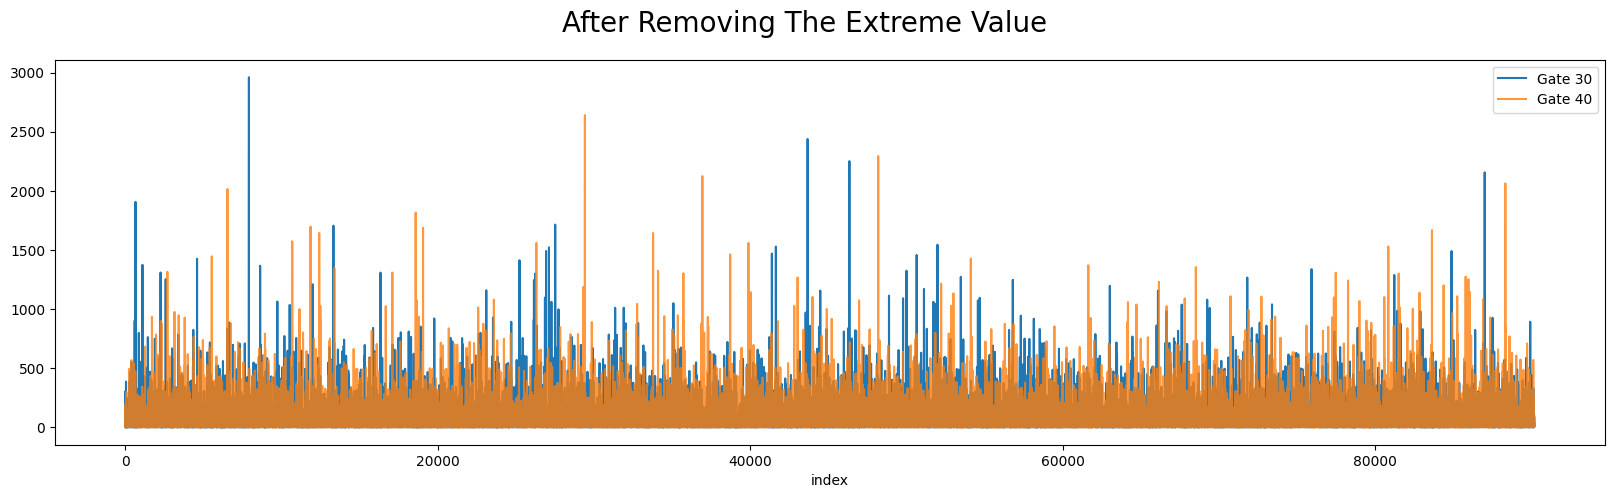

In [84]:
df[(df.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

Now the distribution of Gate_30 and Gate_40 are similar. 

## Analyzing Player Behavior 

In [85]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
2251       1
2294       1
2438       1
2640       1
2961       1
Name: userid, Length: 941, dtype: int64

The users installed the game but 3994 users never played the game! Some reasons might explain this situation.

- They have no free time to play game
- Users might prefer to play other games or they play other games already
- Some users don't like the app (background, music, interface) etc.

The number of users decreases as the levels progress

- Most of users played the game at early stage and they didn't progress.
- Tactile Entertainment should learn why users churn playing the game.
- Doing research and collecting data about the game and users would help to understand user churn
- The difficulty of the game can be measured (too easy to attract users or too difficult to win)
- Gifts might help player retention

In [86]:
df['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

The result shows that 50% of players played less than 16 rounds during the first week after installation, and 75% of players played fewer than 51 rounds.<br/>

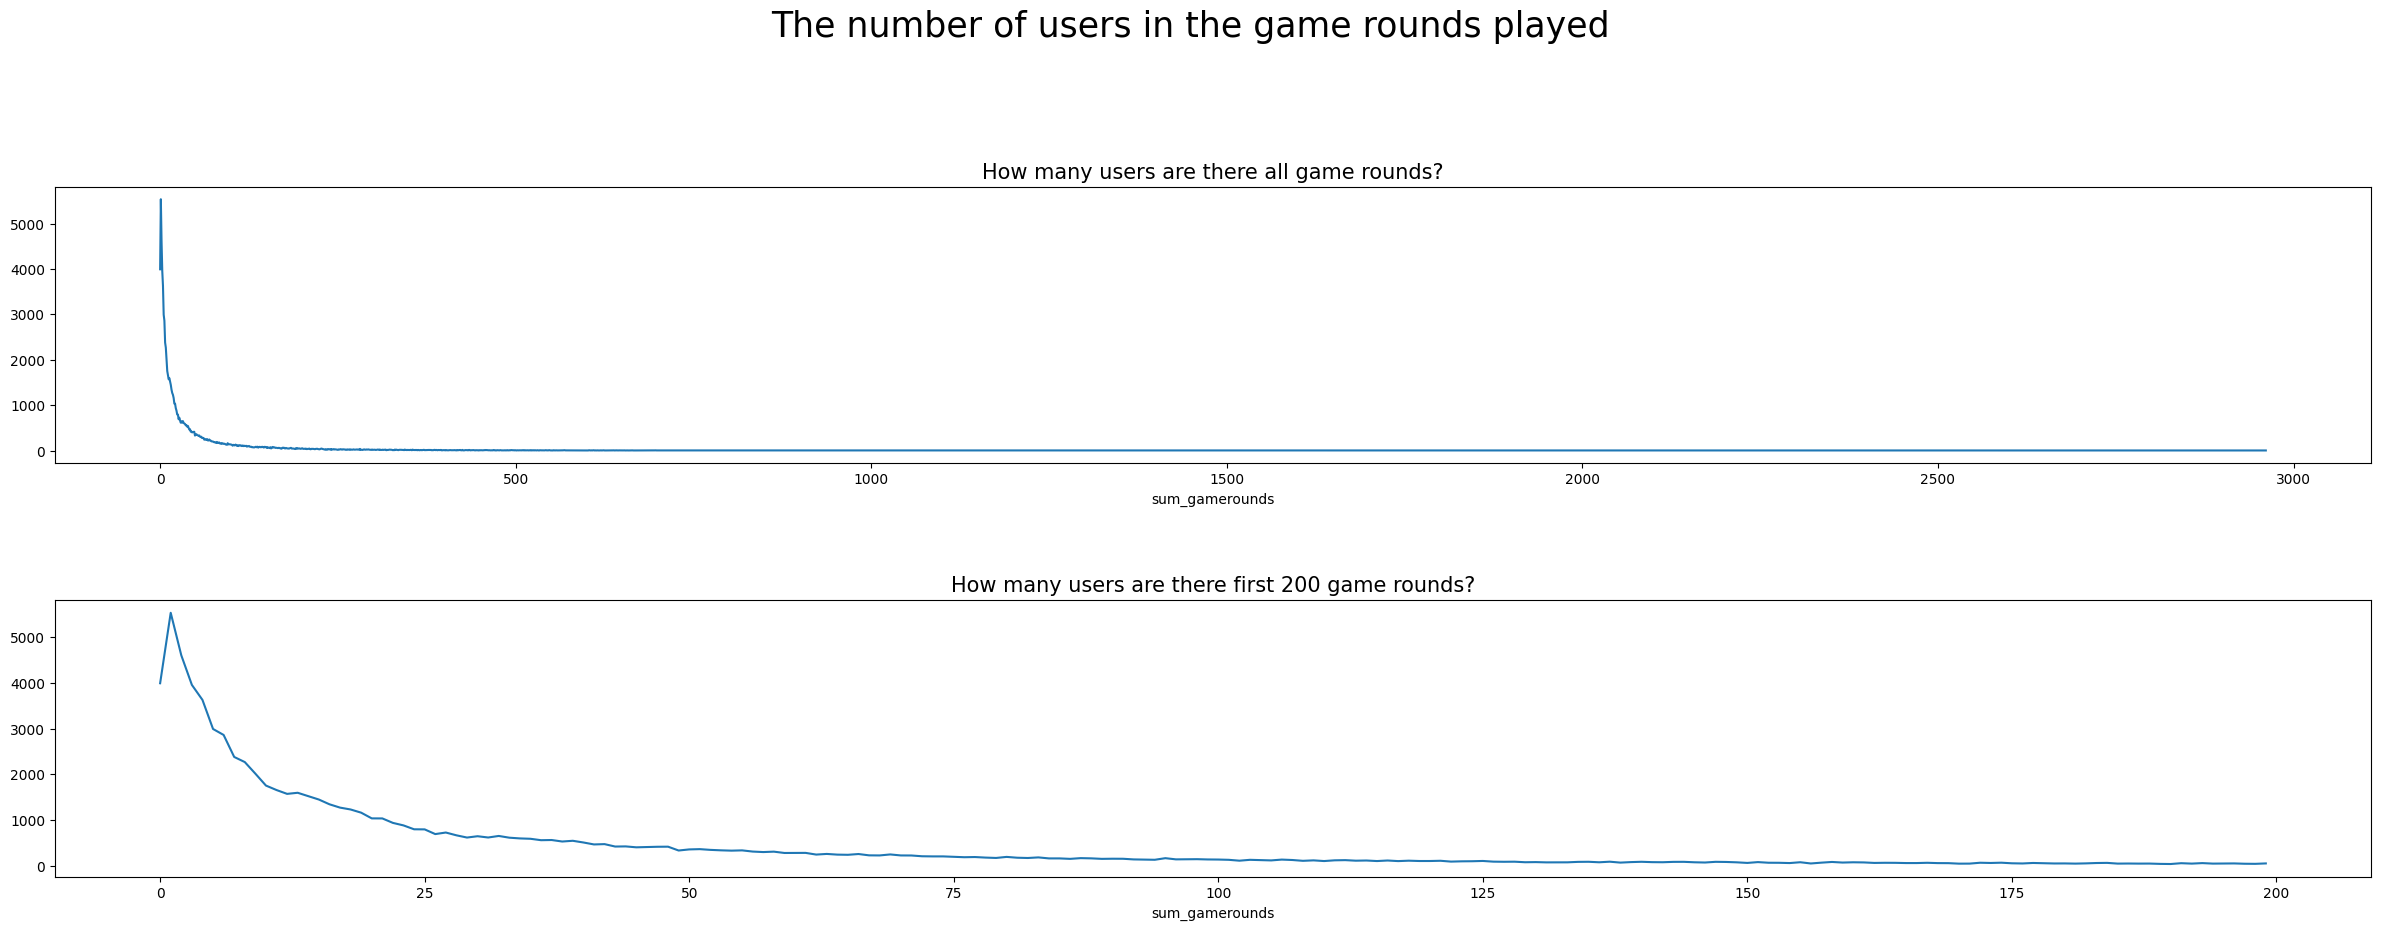

In [87]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
df.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
df.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

The distribution is highly skewed, with a long tail on the right. A huge number of players played fewer than 25 rounds and left the game. For rounds greater than 100, the number of players stayed steady at about 300.

In [88]:
# A/B Groups & Target Summary Stats
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


Looking at the summary statistics, the control and Test groups seem similar, but are the two groups statistically significant?

## AB Testing

In [89]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": df["retention_1"].value_counts(),
              "RET7_COUNT": df["retention_7"].value_counts(),
              "RET1_RATIO": df["retention_1"].value_counts() / len(df),
              "RET7_RATIO": df["retention_7"].value_counts() / len(df)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


Retention variables gives us player retention details.

retention_1 - did the player come back and play 1 day after installing?<br/>
retention_7 - did the player come back and play 7 days after installing?<br/>
Also players tend not to play the game! There are many players who quit the game.<br/>

55 percent of the players didn't play the game 1 day after insalling<br/>
81 percent of the players didn't play the game 7 day after insalling

In [90]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

In [91]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

In [92]:
df["Retention"] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)
df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version Retention                                             
gate_30 0          38023    12.0   28.070273   48.017452  1072
        1           6676   127.0  183.886309  189.626390  2961
gate_40 0          38983    12.0   28.103353   48.927850  2640
        1           6506   133.0  190.282355  194.220077  2294

In [93]:
df["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), df.retention_1, df.retention_7))
df.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


Similar results are seen in the two groups when the number of users who came and did not come 1 day and 7 days after the game was installed.

### Hypothesis
Assumptions:
- Check normality
- If Normal Distribution, check homogeneity

Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [94]:
# Define A/B groups
df["version"] = np.where(df.version == "gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [95]:
# check the sample size for normality test
len(df[df['version'] == "A"]["sum_gamerounds"])
len(df[df['version'] == "B"]["sum_gamerounds"])

44699

45489

In [96]:
from scipy.stats import normaltest
normaltest(df[df['version'] == "A"]["sum_gamerounds"])[1]<0.05
normaltest(df[df['version'] == "B"]["sum_gamerounds"])[1]<0.05

np.True_

np.True_

As the sample size is larger than 5000, Shapiro-Wilk W Test in python for the normality distribution test is not suitable in this situation. Then we use the D’Agostino Omnibus test (normaltest) for testing the normality.

In [97]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import normaltest
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = normaltest(groupA)[1] < 0.05
    ntB = normaltest(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        print("A or B is non-normal Distribution")
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
        
    return temp

In [98]:
# Apply A/B Testing
AB_Test(dataframe= df, group = "version", target = "sum_gamerounds")

A or B is non-normal Distribution
# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!


## Conclusion

In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

Before the test, we found there was an outlier in the sample. After removing the outlier, we had a look about the data and briefly analysing the players' behavior.

In the AB testing, we checked the normality and the homogeneity of the two groups (gate_30 and gate_40) at first. As the sample size is large, we use D’Agostino Omnibus test to check the normality and find out the two groups are not normal. Then we used the Mann-whitney U test to test the two groups because of non-normality. As there is no compelling reason for a directional hypothesis, it is best to use a two-sided test to avoid analysis bias. Finally, we get the results that there is no significant reason to reject the H0, which means the mean of gate_30 and gate_40 are similar.

As a result, it is suggested that moving the gate from level 30 to 40 will not improve the retention or the gamerounds of the players.

## Reference
- https://www.geeksforgeeks.org/outlier/
- https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/notebook
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#id1
- https://courses.washington.edu/psy524a/pdf/Normality_Tests.pdf
- https://www.me.psu.edu/cimbala/me345/Lectures/Two_Samples_Hypothesis_Testing.pdf
- https://stats.libretexts.org/Bookshelves/Applied_Statistics/Learning_Statistics_with_R_-_A_tutorial_for_Psychology_Students_and_other_Beginners_(Navarro)/13%3A_Comparing_Two_Means/13.10%3A__Testing_Non-normal_Data_with_Wilcoxon_Tests
